# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
N = 3004 # len de df

Tp = 754 # int(len*0.85)

np.random.seed(0)
t=np.arange(0, N)
x = (2*np.sin(0.02*t)*np.sin(0.003*t)) + 0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns = ['Data'])
df.head()

,Data
0,0.882026
1,0.200199
2,0.489849
3,1.121526
4,0.935697


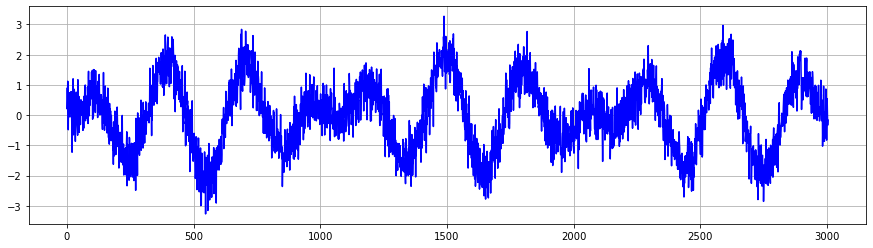

In [3]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True);

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing. 

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [4]:
values = df.values

train = values[:Tp, :]
test = values[Tp:, :]

In [5]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (754, 1)
Test data length: (2250, 1)


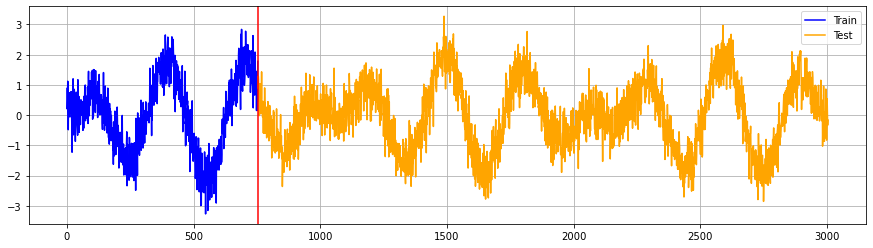

In [10]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[:Tp], train, c='blue')
plt.plot(index[Tp:], test, c='orange')
plt.legend(['Train', 'Test'])
plt.axvline(Tp, c='r')
plt.grid(True);

### Step (or _embedding_)
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=4`. In more complex RNN and in particular for text processing, this is also called _embedding size_.

In [13]:
df2

,Data,lag1,lag2,lag3,lag4
0,0.882026,NaN,NaN,NaN,NaN
1,0.200199,0.882026,NaN,NaN,NaN
2,0.489849,0.200199,0.882026,NaN,NaN
3,1.121526,0.489849,0.200199,0.882026,NaN
4,0.935697,1.121526,0.489849,0.200199,0.882026
...,...,...,...,...,...
2999,-0.277347,-0.828811,-0.303959,-0.646398,0.862306
3000,0.545401,-0.277347,-0.828811,-0.303959,-0.646398
3001,0.019247,0.545401,-0.277347,-0.828811,-0.303959
3002,-0.335919,0.019247,0.545401,-0.277347,-0.828811


In [14]:
df2 = df.copy()
emb_size = 4
for i in range(1, emb_size+1):
    df2['lag' + str(i)] = df2['Data'].shift(i)

df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)

values = df2.values

trainX = values[:Tp-emb_size, 1:] 
trainY = values[:Tp-emb_size, 0]
testX = values[Tp-emb_size: , 1:]
testY = values[Tp-emb_size: , 0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (750, 4)
Train target length: (750,)
Test data length: (2250, 4)
Test target length: (2250,)


In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
trainX[:3]

array([[[ 1.12152594,  0.48984886,  0.2001986 ,  0.88202617]],

       [[ 0.9356969 ,  1.12152594,  0.48984886,  0.2001986 ]],

       [[-0.48564405,  0.9356969 ,  1.12152594,  0.48984886]]])

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(750, 1, 4)

- 750: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [17]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


### Keras model

- 256 neurons in the RNN layer
- 32 neurons in the densely connected layer
- A single neuron for the output layer. Predict a single number
- ReLu activation
- learning rate: 0.001

In [18]:
from tensorflow.keras.layers import Dense, LSTM

def build_simple_rnn(num_units=128, embedding=4, num_dense=32,lr=0.001):
    model = Sequential()
    
    model.add(LSTM(units = num_units,
                  input_shape= (1, embedding),
                  activation='relu'))
    
    model.add(Dense(num_dense, activation = 'relu'))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])
    
    return model

In [19]:
model = build_simple_rnn()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


### A simple callback class to show a message every 50 epochs

In [23]:
'''
Enseña mensaje si la epoch es multiplo de 50 y no ha acabado de entrenar.
Cada vez que termina una epoch, keras llama a on_epoch_end()
'''
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model

Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

- (16, 1, 4)

Cogemos 16 trozos de 1 fila con 4 datos

In [24]:
batch_size=16
num_epochs = 1000

In [25]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


### Plot loss

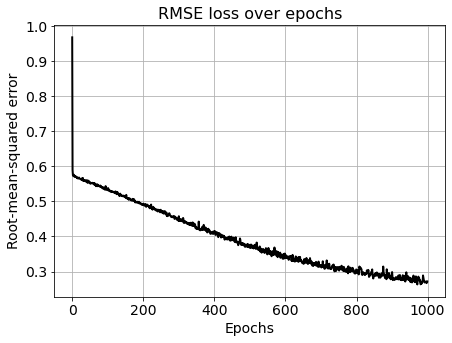

In [26]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data. 

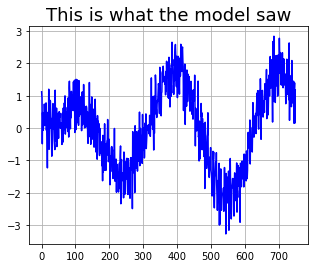

In [27]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [28]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict, testPredict), axis=0)

In [31]:
predicted.shape

(3000, 1)

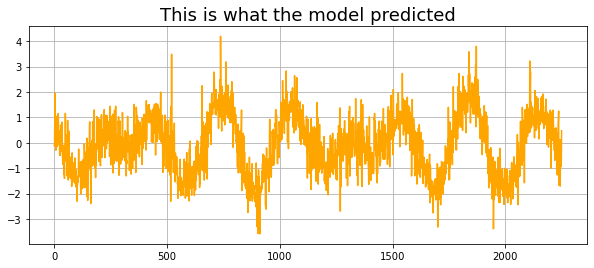

In [29]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True);

### Comparing it with the ground truth (test set)

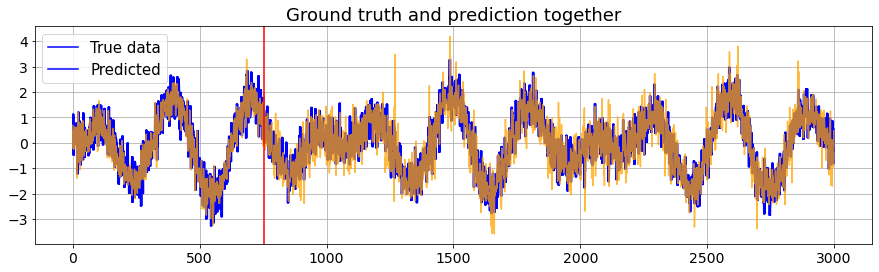

In [30]:
index = df2.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df2,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How are the errors distributed?
The errors, or residuals, as they are called in a regression problem, can be plotted to see if they follow any specific distribution. In the generation process, we injected Gaussian noise, so we expect the error to follow the same pattern, _if the model has been able to fit to the real data correctly_.

In [32]:
error = predicted[Tp:] - df2[Tp:]
error = np.array(error).ravel()

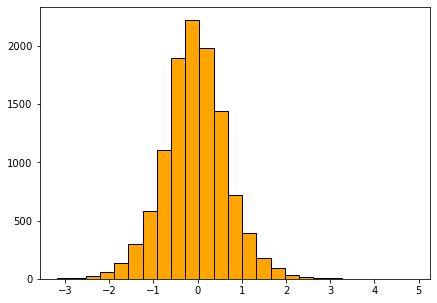

In [33]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange');

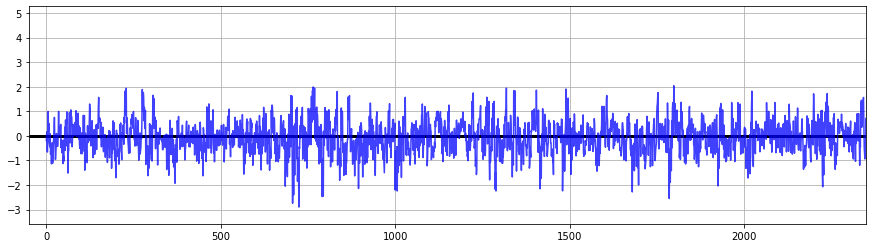

In [34]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True);

## Make the model better

Note, for running these experiments reasonably fast, we will fix the model size to be smaller than the model above. We will use a RNN layer with 32 neurons followed by a densely connected layer of 8 neurons.

### Varying the embedding/step size

In [37]:
def prepare_data(step=4):
    df2 = df.copy()
    emb_size = step
    for i in range(1, emb_size+1):
        df2['lag' + str(i)] = df2['Data'].shift(i)

    df2.dropna(inplace=True)
    df2.reset_index(drop=True, inplace=True)

    values = df2.values

    trainX,trainY = values[0:Tp-emb_size ,1:],values[0:Tp-emb_size ,0],
    testX,testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY,df2

In [ ]:
from tensorflow.keras.layers import Dense, LSTM

def build_simple_rnn(num_units=128, embedding=4, num_dense=32,lr=0.001):
    model = Sequential()
    
    model.add(LSTM(units = num_units,
                  input_shape= (1, embedding),
                  activation='relu'))
    
    model.add(Dense(num_dense, activation = 'relu'))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])
    
    return model

In [35]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [36]:
def plot_compare(predicted, df2):
    index = df2.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df2,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df2.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def errors(testX, testY):
    y_true = testY
    y_pred = model.predict(testX)
    
    return mean_absolute_error(y_true = y_true, y_pred = y_pred)

Embedding size: 2
MAE: 0.4660861918857856
----------------------------------------------------------------------------------------------------


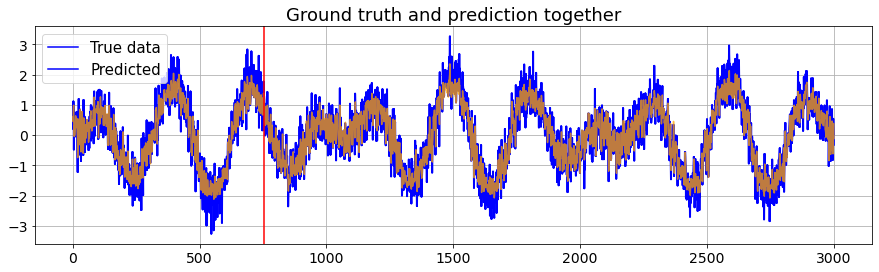


Embedding size: 4
MAE: 0.4340800572052116
----------------------------------------------------------------------------------------------------


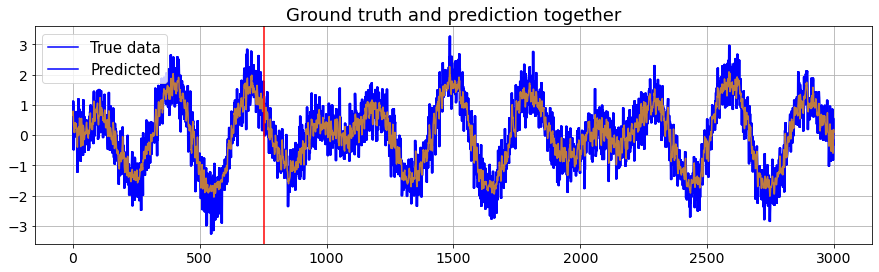


Embedding size: 6
MAE: 0.42488027105832527
----------------------------------------------------------------------------------------------------


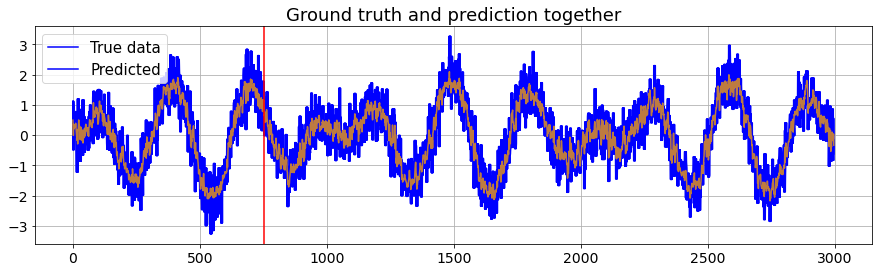


Embedding size: 8
MAE: 0.44137626119253504
----------------------------------------------------------------------------------------------------


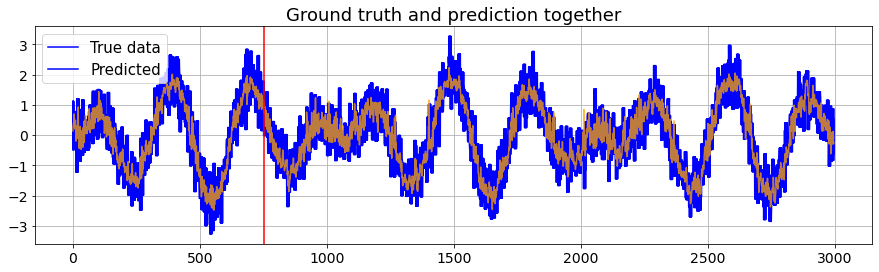


Embedding size: 10
MAE: 0.44192291578287624
----------------------------------------------------------------------------------------------------


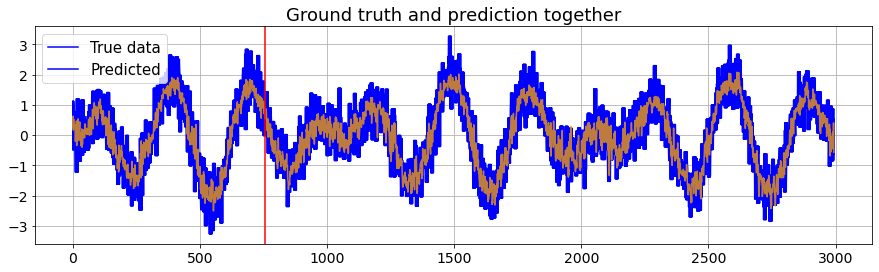


Embedding size: 12
MAE: 0.4553501162397896
----------------------------------------------------------------------------------------------------


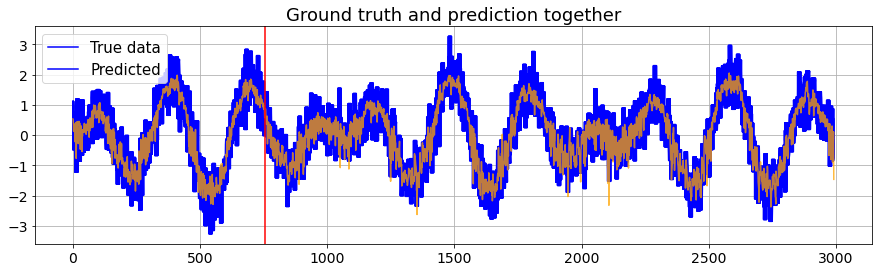

In [39]:
for s in [2,4,6,8,10,12]:
    trainX,testX,trainY,testY,df2 = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Number of epochs

Ran for 100 epochs
MAE: 0.4296979486462659
----------------------------------------------------------------------------------------------------


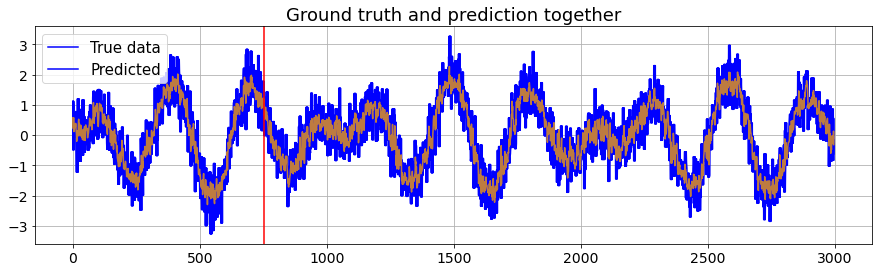


Ran for 200 epochs
MAE: 0.436756839785046
----------------------------------------------------------------------------------------------------


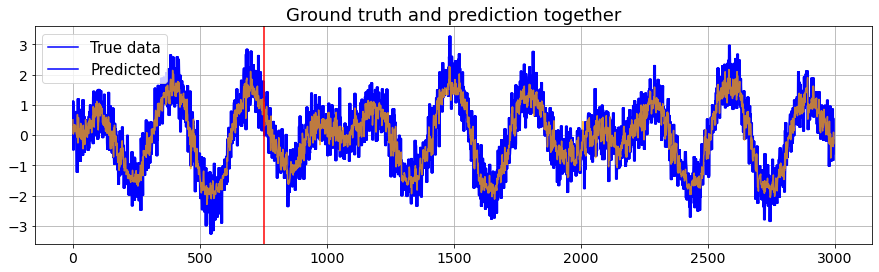


Ran for 300 epochs
MAE: 0.44883270960817845
----------------------------------------------------------------------------------------------------


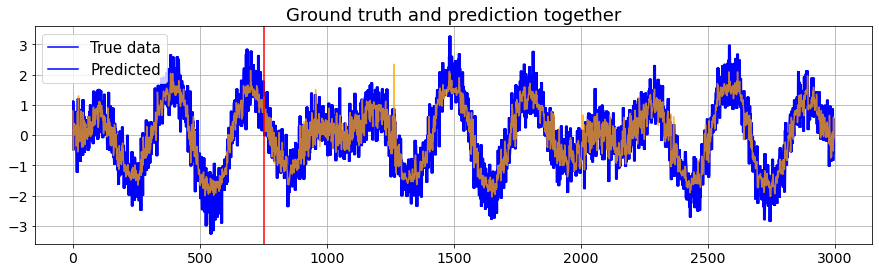


Ran for 400 epochs
MAE: 0.46537637121608605
----------------------------------------------------------------------------------------------------


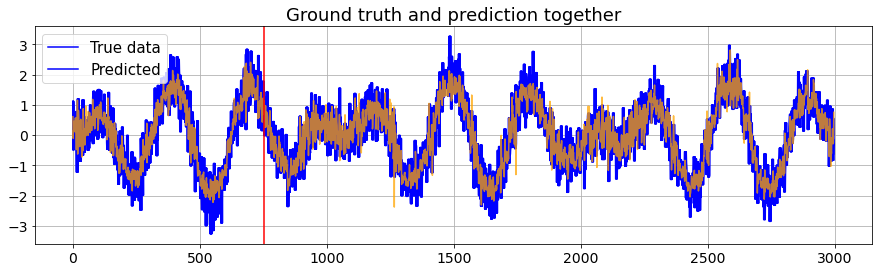


Ran for 500 epochs
MAE: 0.4740237201001732
----------------------------------------------------------------------------------------------------


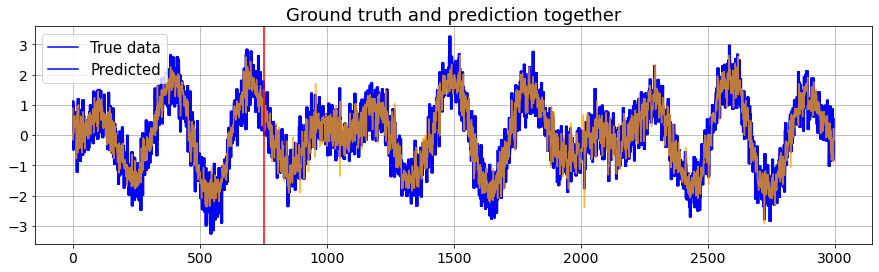

In [40]:
'''
Probemos ahora con una ventana grande (6), y unas cuantas epochs mas
'''
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY, df2 = prepare_data(6)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=6)
    batch_size=16
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=e, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Batch size

Ran with batch size: 4
MAE: 0.47240287712581236
----------------------------------------------------------------------------------------------------


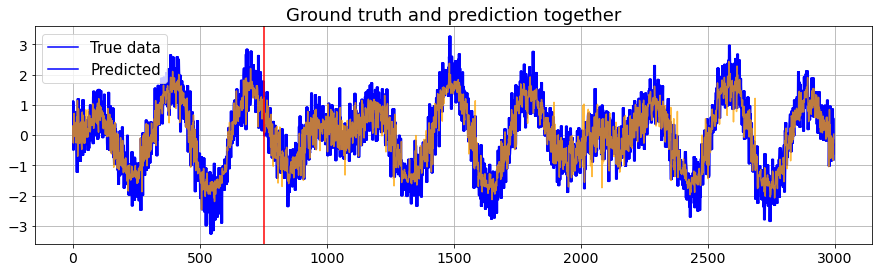


Ran with batch size: 8
MAE: 0.4639375242205806
----------------------------------------------------------------------------------------------------


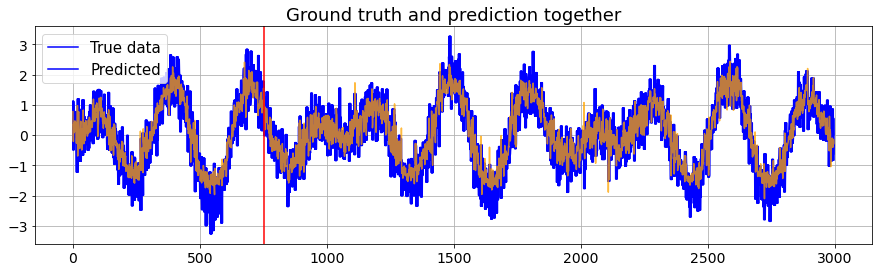


Ran with batch size: 16
MAE: 0.45238006112429024
----------------------------------------------------------------------------------------------------


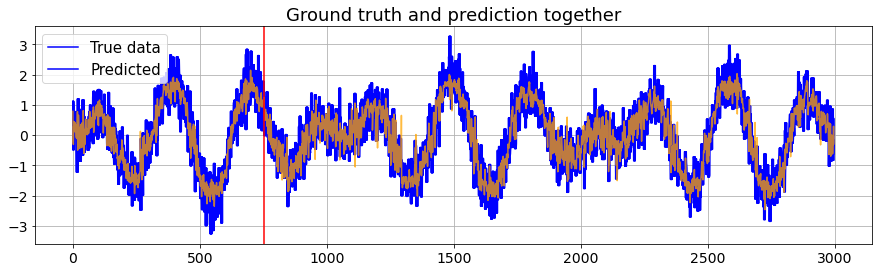


Ran with batch size: 32
MAE: 0.44361827238329105
----------------------------------------------------------------------------------------------------


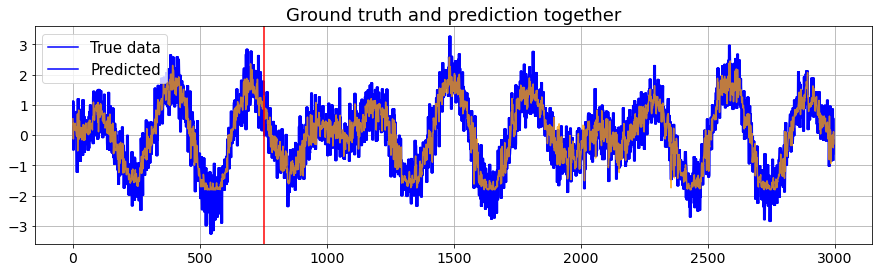


Ran with batch size: 64
MAE: 0.42907937389942824
----------------------------------------------------------------------------------------------------


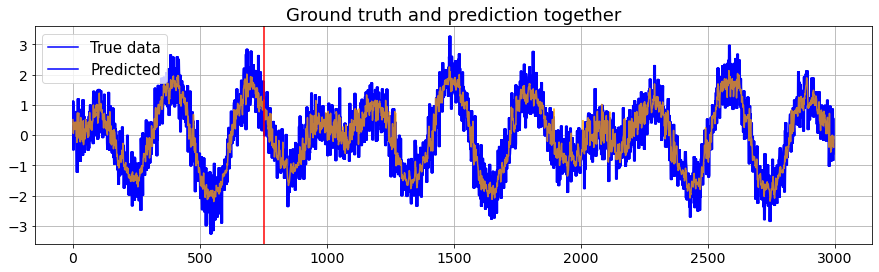

In [41]:
for b in [4,8,16,32,64]:
    trainX,testX,trainY,testY, df2 = prepare_data(6)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=6)
    batch_size=b
    num_epochs = 250
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=b,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Summary

Clearly, following trends were observed,

- Too small embedding size is not useful but a very long embedding is also not effective. An embedding of 8 looks good for this data.
- More epochs are not always better. Probably we are suffering overfitting
- A batch size of 32 or 64 looks optimal.

Ultimately, an exhaustive hyperparameter tuning is needed for the best overall performance.